In [1]:
import torch 
import matplotlib.pyplot as plt
from markov_chain_monte_carlo import *
from IPython.display import clear_output
from utils import * 
from conditional_density_estimation import * 
from misc import * 

In [2]:
sigma=.35
D_x = torch.cat([torch.linspace(-7.5,-2.5,1000),torch.linspace(-2.5,2.5,100),torch.linspace(2.5,7.5,1000)])
D_y = 2*torch.cos(D_x) + sigma * torch.randn_like(D_x)
x0 = torch.rand(1)*15 - 7.5
y0 = 2*torch.cos(x0) + sigma * torch.randn_like(x0)

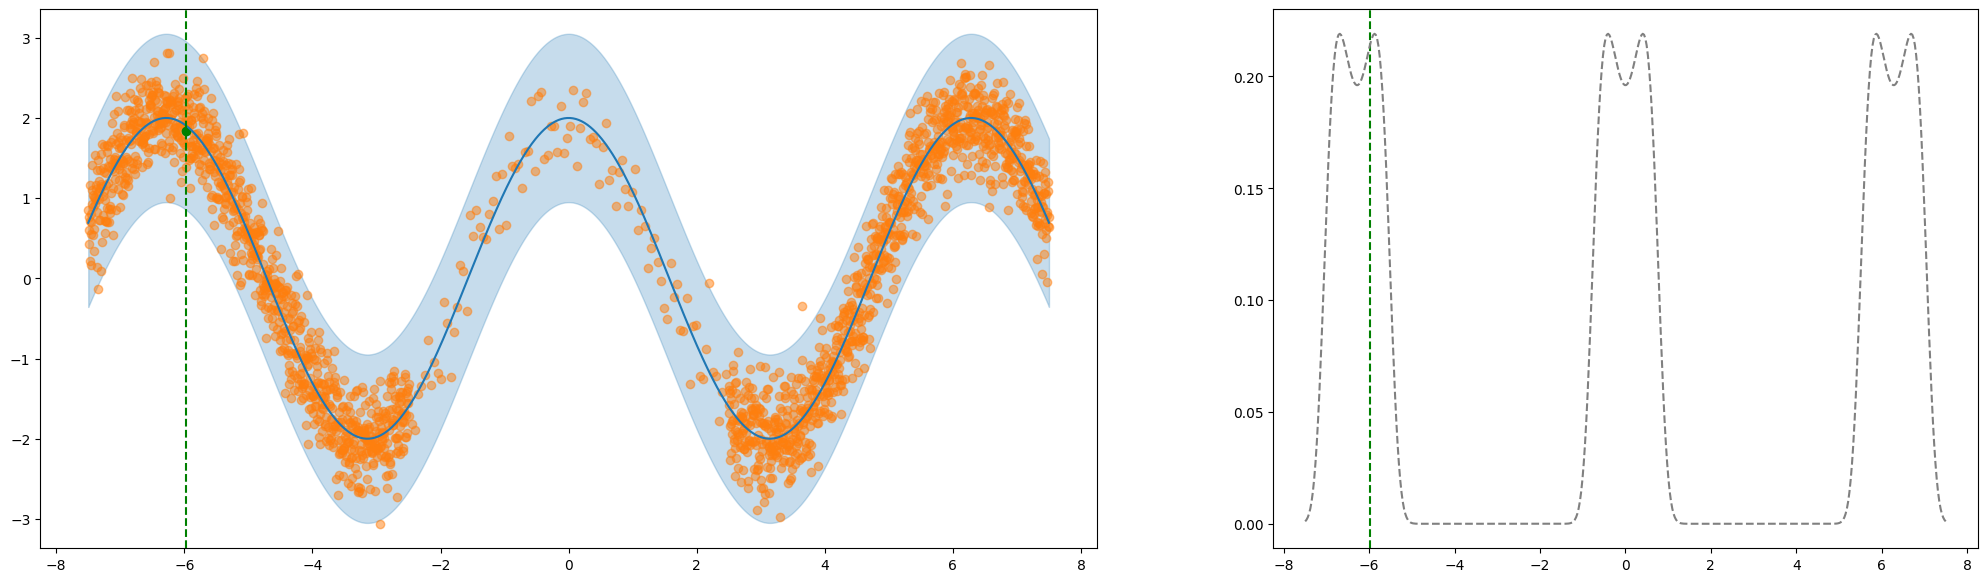

<Figure size 640x480 with 0 Axes>

In [5]:
fig = plt.figure(figsize = (25,7))
ax = fig.subplots(1, 2, gridspec_kw={'width_ratios': [3, 2]}, squeeze = True)
tt = torch.linspace(-7.5,7.5,1000)
ax[0].plot(tt, 2*torch.cos(tt), color = 'C0')
ax[0].fill_between(tt,  2*torch.cos(tt) - 3*sigma,  2*torch.cos(tt) + 3*sigma, color = 'C0', alpha = .25)
ax[0].scatter(D_x, D_y, color = 'C1', alpha = .5)
ax[0].axvline(x0.numpy(), linestyle = '--', color = 'green')
ax[0].scatter(x0,y0, color = 'green')

posterior = lambda x0: torch.exp(torch.distributions.Normal(2*torch.cos(x0), sigma).log_prob(y0))
ax[1].axvline(x0.numpy(), linestyle = '--', color = 'green')
plot_1d_unormalized_function(posterior, range = (-7.5, 7.5), bins = 500, color = 'grey', linestyle = '--')
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()

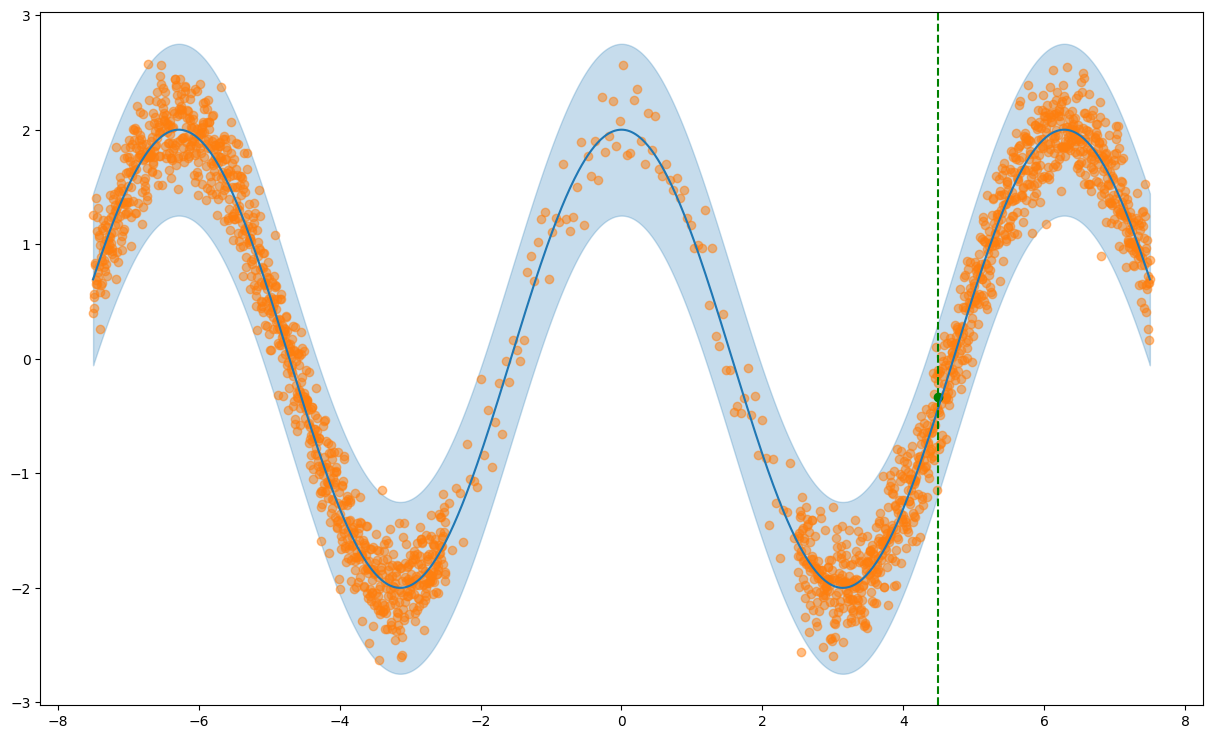

In [26]:
plt.figure(figsize = (15,9))
tt = torch.linspace(-7.5,7.5,1000)
plt.plot(tt, 2*torch.cos(tt), color = 'C0')
plt.fill_between(tt,  2*torch.cos(tt) - 3*sigma,  2*torch.cos(tt) + 3*sigma, color = 'C0', alpha = .25)
plt.scatter(D_x, D_y, color = 'C1', alpha = .5)
plt.axvline(x0.numpy(), linestyle = '--', color = 'green')
plt.scatter(x0,y0, color = 'green')


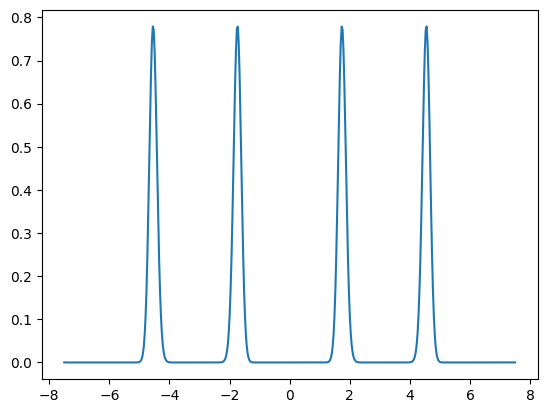

In [24]:
posterior = lambda x0: torch.exp(torch.distributions.Normal(2*torch.cos(x0), sigma).log_prob(y0))
plot_1d_unormalized_function(posterior, range = (-7.5, 7.5), bins = 500)

 ... (more hidden) ...


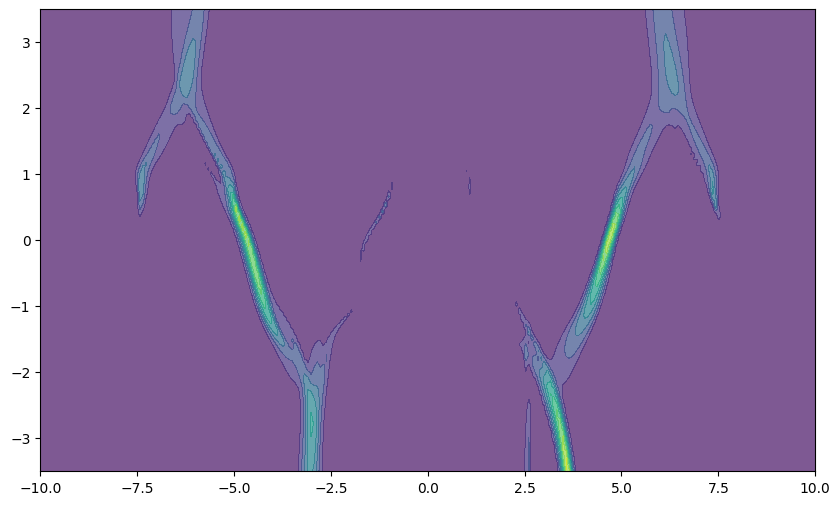

In [13]:
discriminative_model = ConditionalDIF(D_x.unsqueeze(-1),D_y.unsqueeze(-1),10,[128,128,128])
discriminative_model.initialize_with_EM(100, verbose = True)
discriminative_model.train(500,lr = 5e-4)
models.append(discriminative_model)
plot_likelihood_function(lambda x,y:torch.mean(torch.cat([model.log_prob(y,x).unsqueeze(-1) for model in models], dim = -1), dim = -1), range = ((-10,10), (-3.5,3.5)), bins = (250,250), levels = 10)

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


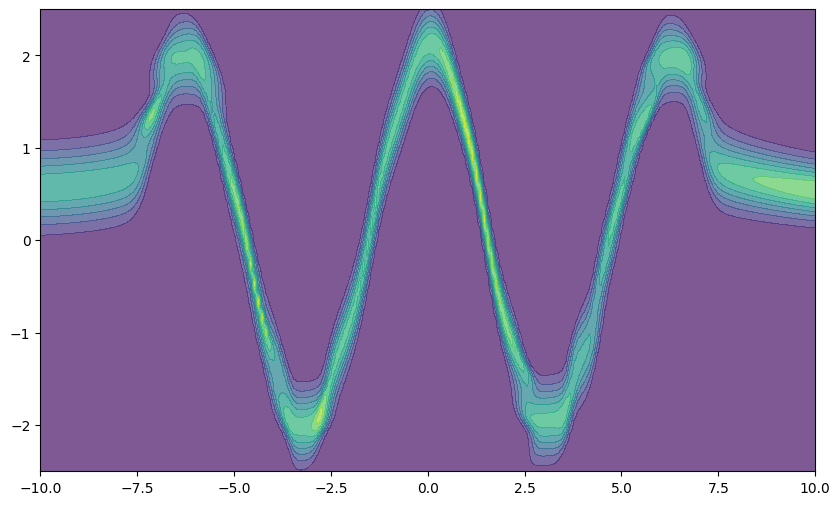

In [25]:
generative_model = ConditionalDIF(D_y.unsqueeze(-1),D_x.unsqueeze(-1),10,[128,128,128])
generative_model.initialize_with_EM(50, verbose = True)
generative_model.train(100,500,lr = 5e-3, verbose = True)
generative_model.train(100,500,lr = 5e-4, verbose = True)
generative_model.train(100,500,lr = 5e-5, verbose = True)
plot_likelihood_function(generative_model.log_prob, range = ((-10,10), (-2.5,2.5)), bins = (200,200), levels = 10)

In [ ]:
window = 2
mask = torch.abs(D_x)>window
x0 = D_x[~mask]
y0 = D_y[~mask]
D_x = D_x[mask]
D_y = D_y[mask]
plt.scatter(D_x, D_y)
plt.scatter(x0, y0)

In [ ]:
discriminative_model = ConditionalDIF(D_x.unsqueeze(-1),D_y.unsqueeze(-1),10,[128,128,128])
discriminative_model.initialize_with_EM(50, verbose = True)
discriminative_model.train(100,500,lr = 5e-3, verbose = True)
discriminative_model.train(100,500,lr = 5e-4, verbose = True)
discriminative_model.train(100,500,lr = 5e-5, verbose = True)

In [ ]:
plot_likelihood_function(lambda x,y:discriminative_model.log_prob(y,x), range = ((-10,10), (-2.5,2.5)), bins = (200,200), levels = 10)

In [ ]:
log_posterior =lambda x: discriminative_model.log_prob(x,y0.unsqueeze(-1))
sampler = IndependentMetropolisHastings_multiple_obs(log_posterior,1, y0.shape[0], Uniform(torch.tensor([-8]), torch.tensor([8])))
samples = sampler.sample(100, verbose = True)
clear_output(wait = True)
plt.scatter(samples, y0, color = 'green')
plt.scatter(D_x, D_y)

In [ ]:
prior = Uniform(torch.tensor([-window]), torch.tensor([window]))

total_samples = []
total_models = []
for _ in range(5):
    generative_model = ConditionalDIF(D_y.unsqueeze(-1),D_x.unsqueeze(-1),3,[32,32,32])
    generative_model.initialize_with_EM(50)
    generative_model.train(100,500,lr = 5e-3, verbose = True)
    generative_model.train(100,500,lr = 5e-4, verbose = True)
    generative_model.train(100,500,lr = 5e-5, verbose = True)
    total_models.append(generative_model)
def plot_average_likelihood_function(log_likelihood_list, range = [[-10,10],[-10,10]], bins = [50,50], levels = 2 , alpha = 0.7, figsize = (10,6), show = True):
    total_log_likelihood = lambda y, x: torch.logsumexp(
        torch.cat([log_likelihood(y, x).unsqueeze(0) for log_likelihood in log_likelihood_list], dim=0), dim=0)
    plot_likelihood_function(total_log_likelihood, range=range, bins = bins, levels = levels, alpha = alpha, figsize = figsize, show = show)

plot_average_likelihood_function([model.log_prob for model in total_models], range = ((-10,10), (-2,2)), bins= (200,200), levels = 20)

In [ ]:
from targets import *
window = 2
D_x = torch.linspace(-9,9,5000)
D_y = torch.cos(D_x) + 0.125 * torch.randn_like(D_x)
mask = torch.abs(D_x)>window
x0 = D_x[~mask].unsqueeze(-1)
y0 = D_y[~mask].unsqueeze(-1)
D_x = D_x[mask].unsqueeze(-1)
D_y = D_y[mask].unsqueeze(-1)
plt.scatter(D_x, D_y)
plt.scatter(x0, y0)
total_samples = []
total_models = []
D_y_plus = D_y
D_x_plus = D_x
for _ in range(50):
    generative_model = ConditionalDIF(D_y_plus,D_x_plus,3,[32,32,32])
    generative_model.initialize_with_EM(50)
    generative_model.train(100,500,lr = 5e-3, verbose = True)
    generative_model.train(100,500,lr = 5e-4, verbose = True)
    generative_model.train(100,500,lr = 5e-5, verbose = True)

    joint_log_posterior =lambda x: generative_model.log_prob(y0, x)+ prior.log_prob(x)
    sampler = IndependentMetropolisHastings_multiple_obs(joint_log_posterior,1, y0.shape[0], prior)
    samples = sampler.sample(100, verbose = True)
    clear_output(wait = True)
    plt.scatter(samples, y0, color = 'green')
    plt.scatter(D_x, D_y)
    plt.show()
    D_x_plus = torch.cat([D_x, samples], dim=0)
    D_y_plus = torch.cat([D_y, y0], dim = 0)
    total_samples.append(samples)
    total_models.append(generative_model)

In [ ]:
def plot_average_likelihood_function(log_likelihood_list, range = [[-10,10],[-10,10]], bins = [50,50], levels = 2 , alpha = 0.7, figsize = (10,6), show = True):
    total_log_likelihood = lambda y, x: torch.logsumexp(
        torch.cat([log_likelihood(y, x).unsqueeze(0) for log_likelihood in log_likelihood_list], dim=0), dim=0)
    plot_likelihood_function(total_log_likelihood, range=range, bins = bins, levels = levels, alpha = alpha, figsize = figsize, show = show)

plot_average_likelihood_function([model.log_prob for model in total_models], range = ((-10,10), (-2,2)), bins= (200,200), levels = 20)